<a href="https://colab.research.google.com/github/ucheokechukwu/Stock-Prediction-with-Media-Sentiment-Analysis-/blob/main/src/Feature_Engineering_Baseline_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bitcoin data source: https://coincodex.com/crypto/bitcoin/historical-data/

NFLX data source:

- https://www.nasdaq.com/market-activity/stocks/nflx/historical

- https://finance.yahoo.com/quote/nflx/history/?guccounter=1

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model




In [4]:
import pandas as pd
import numpy as np


In [214]:
pd.read_csv('/content/bitcoin_2018-06-14_2023-06-13.csv')

,Date,Open,High,Low,Close,Volume,Market Cap
0,Jun-12-2023,25922.890000,26081.610000,25662.950000,25887.590000,3.018877e+10,5.018320e+11
1,Jun-11-2023,25820.230000,26147.840000,25676.590000,25920.860000,3.299485e+10,5.011299e+11
2,Jun-10-2023,26481.470000,26500.500000,25491.910000,25842.840000,3.586479e+10,5.009359e+11
3,Jun-09-2023,26509.380000,26766.280000,26325.910000,26489.460000,2.879870e+10,5.143227e+11
4,Jun-08-2023,26341.330000,26762.750000,26235.140000,26493.460000,3.797578e+10,5.132887e+11
...,...,...,...,...,...,...,...
1820,Jun-18-2018,6460.218405,6724.301589,6400.071429,6700.596021,2.259400e+09,1.112652e+11
1821,Jun-17-2018,6500.435004,6541.234834,6459.314001,6461.213025,2.039620e+09,1.112224e+11
1822,Jun-16-2018,6469.496413,6514.550897,6395.022991,6505.755311,2.350149e+09,1.103236e+11
1823,Jun-15-2018,6650.926765,6652.572392,6470.053174,6473.773491,3.114118e+09,1.122367e+11


In [215]:
data = pd.read_csv('/content/bitcoin_2018-06-14_2023-06-13.csv',
                   parse_dates = ['Date'],
                   index_col = ['Date']).sort_index(ascending=True)
data

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-06-14,6307.588850,6667.673554,6293.277845,6649.438347,3.663603e+09,1.110145e+11
2018-06-15,6650.926765,6652.572392,6470.053174,6473.773491,3.114118e+09,1.122367e+11
2018-06-16,6469.496413,6514.550897,6395.022991,6505.755311,2.350149e+09,1.103236e+11
2018-06-17,6500.435004,6541.234834,6459.314001,6461.213025,2.039620e+09,1.112224e+11
2018-06-18,6460.218405,6724.301589,6400.071429,6700.596021,2.259400e+09,1.112652e+11
...,...,...,...,...,...,...
2023-06-08,26341.330000,26762.750000,26235.140000,26493.460000,3.797578e+10,5.132887e+11
2023-06-09,26509.380000,26766.280000,26325.910000,26489.460000,2.879870e+10,5.143227e+11
2023-06-10,26481.470000,26500.500000,25491.910000,25842.840000,3.586479e+10,5.009359e+11


In [78]:
data.tail()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-06-08,26341.33,26762.75,26235.14,26493.46,3.797578e+10,5.132887e+11
2023-06-09,26509.38,26766.28,26325.91,26489.46,2.879870e+10,5.143227e+11
2023-06-10,26481.47,26500.50,25491.91,25842.84,3.586479e+10,5.009359e+11
2023-06-11,25820.23,26147.84,25676.59,25920.86,3.299485e+10,5.011299e+11
2023-06-12,25922.89,26081.61,25662.95,25887.59,3.018877e+10,5.018320e+11


In [220]:
data = data['Close'].to_frame()
data

,Close
Date,
2018-06-14,6649.438347
2018-06-15,6473.773491
2018-06-16,6505.755311
2018-06-17,6461.213025
2018-06-18,6700.596021
...,...
2023-06-08,26493.460000
2023-06-09,26489.460000
2023-06-10,25842.840000


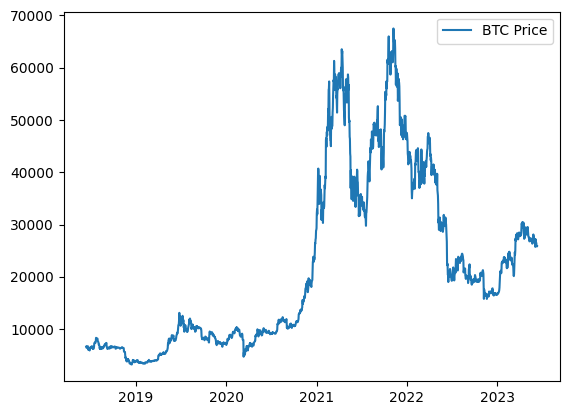

In [80]:
import matplotlib.pyplot as plt
plt.plot(data, label='BTC Price')
plt.legend()
plt.show()

## Creating Train & Test Splits

In [221]:
split = int(0.8 * len(data))
train, test = data[:split], data[split:]

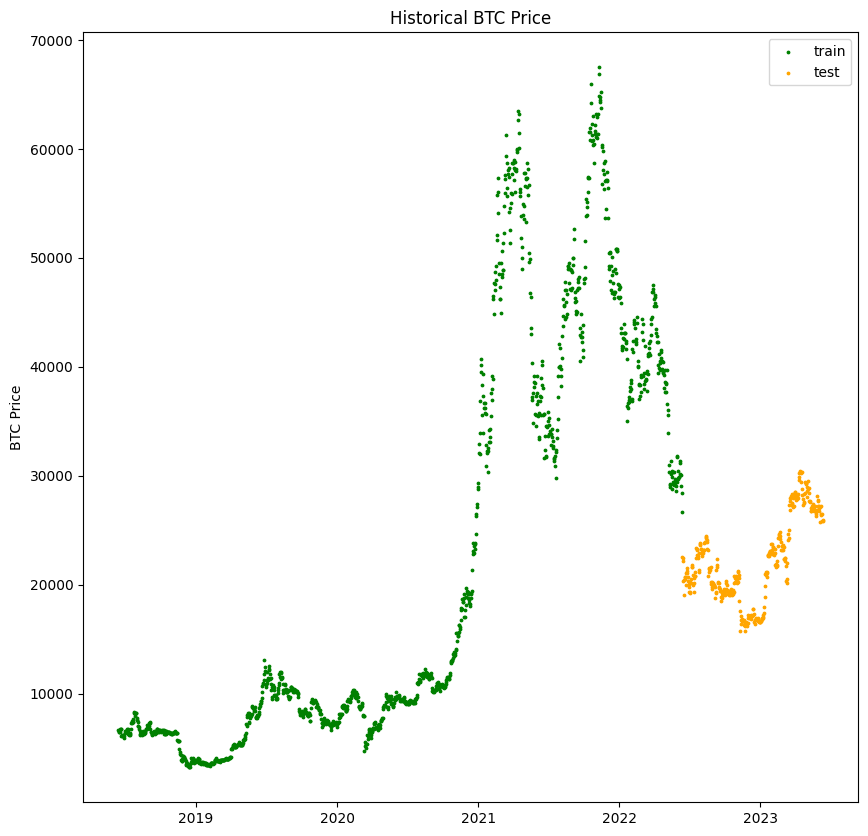

In [84]:
# plotting train, test data
plt.figure(figsize=(10,10))

plt.scatter(train.index, train, color='green', label='train', s=3)
plt.scatter(test.index, test, color='orange', label='test', s=3)
plt.ylabel('BTC Price')
plt.legend()
plt.title('Historical BTC Price')
plt.show()

# Baseline Model: Naive Forecast

X[t+1] = X[t]

In [86]:
# shifting the data by one day
data.shift(periods=1)
pred = test.shift(periods=1)
display(pred.head())
display(pred.tail())
test.tail()


,Close
Date,
2022-06-13,NaN
2022-06-14,22509.099400
2022-06-15,22209.515000
2022-06-16,22490.590727
2022-06-17,20383.688900


,Close
Date,
2023-06-08,26359.59
2023-06-09,26493.46
2023-06-10,26489.46
2023-06-11,25842.84
2023-06-12,25920.86


,Close
Date,
2023-06-08,26493.46
2023-06-09,26489.46
2023-06-10,25842.84
2023-06-11,25920.86
2023-06-12,25887.59


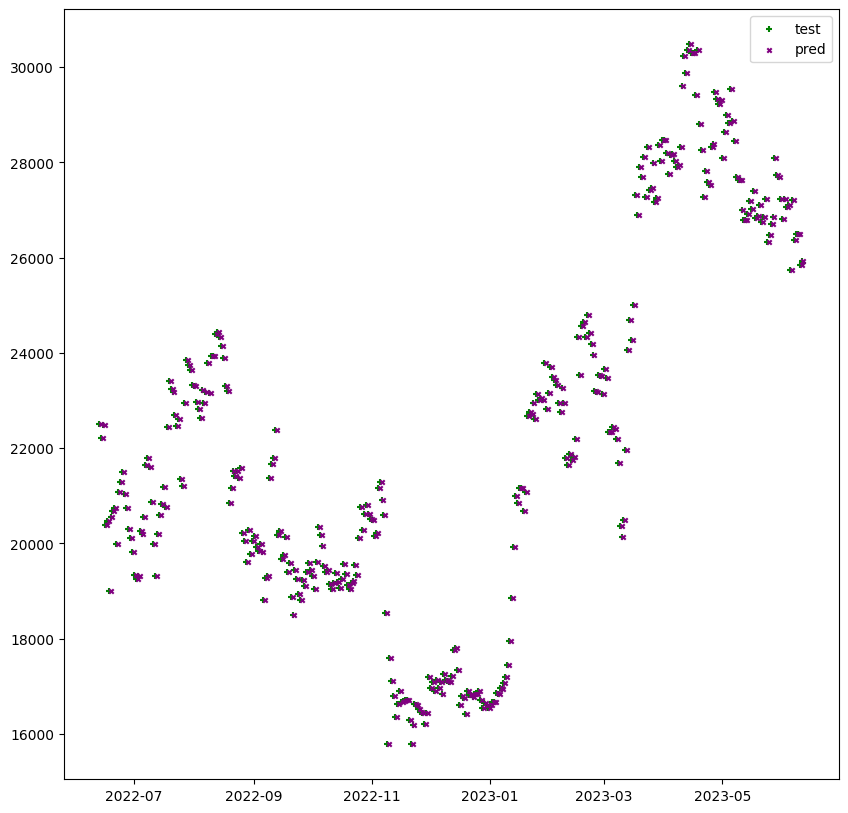

In [87]:
# visualizing this
plt.figure(figsize=(10,10))
# plt.scatter(train.index, train, color='green', label='train', s=4)
plt.scatter(test.index, test, color='green', label='test', s=20, marker="+")
plt.scatter(pred.index, pred, color='purple', label='pred', s=10, marker="x")
plt.legend()

## Evaluating performance

In [ ]:
from sklearn.metrics import r2_score

def mean_absolute_scaled_error(y_true, y_pred, period=1):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[period:] - y_true[:-period]))
  # our seasonality is 1 day (hence the shifting of 1 day)
  return mae / mae_naive_no_season

def r2score(y_true, y_pred, period=1):
    return r2_score(y_true, y_pred)

from tensorflow_addons.metrics import RSquare
# model.compile(loss='mse', optimizer='rmsprop', metrics=[RSquare()])



In [466]:
error_dict = {}
error_dict['baseline'] = mean_absolute_scaled_error(y_true = test.values[1:],
                                            y_pred = pred.values[1:])
error_dict

{'baseline': <tf.Tensor: shape=(), dtype=float64, numpy=0.9992023040796317>}

## Windowing Dataset

To turn time series into supervised learning problem using the **Sliding Windows** approach.

In [91]:
display(data.head())

,Close
Date,
2018-06-14,6649.438347
2018-06-15,6473.773491
2018-06-16,6505.755311
2018-06-17,6461.213025
2018-06-18,6700.596021


In [401]:
def make_windows(df, window_size=3, horizon=1):
    """
    Input: 1-D time series
    output: X 2D time series of window_size
    y: 1D time series lagged by horizon
    """
    data = df.copy()

    windows = list(data.rolling(window=window_size))[window_size:]
    window_data = pd.concat([pd.DataFrame(window.T.values) for window in windows])
    window_data.index = data.index[window_size:]

    X = window_data[:-horizon].shift(horizon, freq='D')
    y = data[window_size+horizon:]
    print(f"The shape of X is {X.shape} and the size of y is {y.shape}")
    print("Testing that the indices are aligned:")

    display(pd.merge(X, y, left_index=True, right_index=True))
    # return X, y

# Model 1

A single dense layer with
- 128 hidden units and ReLU(rectified linear unit) activation

An output layer with
- linear activation (or no activation)
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs


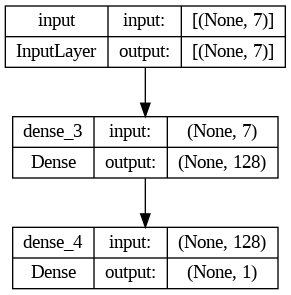

In [426]:
# set random seed for reproducible results
tf.random.set_seed(88)
# construct model
input = layers.Input(shape=(3,), name='input')
hidden = layers.Dense(128, activation='relu')(input)
output = layers.Dense(1, activation='linear')(hidden)


model1 = tf.keras.Model(inputs=input,
                         outputs=output,
                         name="model_1")

plot_model(model, show_shapes=True)

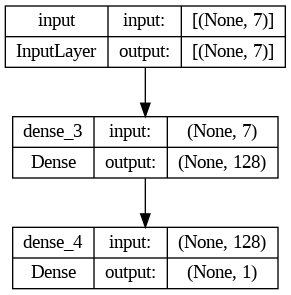

In [443]:
plot_model(model, show_shapes=True)

In [444]:
# function to train test split the X and y
def train_test_splits(X, y, test_split=0.2):
  """
  Input: X and y
  Output: X_train, X_test, y_train, y_test in that order
  """
  split = round(len(X) * (1-test_split))
  # returns in order: X_train, X_test, y_train, y_test
  display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X[:split], X[split:], y[:split], y[split:]


X_train, X_test, y_train, y_test = train_test_splits(X, y, test_split=0.2)

(1457, 3)

(364, 3)

(1457, 1)

(364, 1)

In [452]:
# modelling checkpoint
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=4)

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_num, filepath="model_checkpoints"):
    return ModelCheckpoint(filepath=os.path.join(filepath, 'model_num'),
                                            verbose=0,
                                            save_best_only=True)

In [440]:
train_dataset, test_dataset = convert_to_tfDataset(X,y, batch=128)
# Compile model
model1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

(1457, 3)

(364, 3)

(1457, 1)

(364, 1)

In [458]:
# Fit model
model1.fit(X_train,
           y_train,
           epochs=100,
           verbose=1,
           batch_size=128,
           validation_data=(X_test, y_test),
           callbacks=[early_stop]
           ) # create ModelCheckpoint callback to save best model

Epoch 1/100
12/12 [==============================] - 1s 18ms/step - loss: 721.0359 - mae: 721.0359 - val_loss: 593.8201 - val_mae: 593.8201
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 680.1937 - mae: 680.1937 - val_loss: 475.6611 - val_mae: 475.6611
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 638.8096 - mae: 638.8096 - val_loss: 446.4136 - val_mae: 446.4136
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 633.9338 - mae: 633.9338 - val_loss: 447.9650 - val_mae: 447.9650
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 634.7895 - mae: 634.7895 - val_loss: 444.3035 - val_mae: 444.3035
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 637.5113 - mae: 637.5113 - val_loss: 445.9673 - val_mae: 445.9673
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 624.9636 - mae: 624.9636 - val_loss: 443.8273 - val_mae: 443.8273
Epoch 8/100
12/12 [=======

In [467]:
mean_absolute_scaled_error(y_test.values, model1.predict(X_test), period=1)

12/12 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=1.0426129621130213>

In [468]:
error_dict['model1'] = mean_absolute_scaled_error(y_true = y_test.values,
                                            y_pred = model1.predict(X_test))
error_dict

12/12 [==============================] - 0s 2ms/step


{'baseline': <tf.Tensor: shape=(), dtype=float64, numpy=0.9992023040796317>,
 'model1': <tf.Tensor: shape=(), dtype=float64, numpy=1.0426129621130213>}